# Predicting Tax Avoidance Categories

## Data Preparation

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### 1. Load the prepared datasets

In [36]:
train_fe = pd.read_csv('../data/train_fe.csv')
test_fe = pd.read_csv('../data/test_fe.csv')

train_fe.sample(10)
test_fe.sample(10)

train_fe.info()
test_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Columns: 116 entries, Unnamed: 0 to cash_holdings_past
dtypes: float64(57), int64(57), object(2)
memory usage: 3.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Columns: 116 entries, Unnamed: 0 to cash_holdings_past
dtypes: float64(57), int64(57), object(2)
memory usage: 329.1+ KB


### 2.Create the target classification variable

In [37]:
def create_target(df):
    etr_classification = []


    for col in df['etr']:
        if col > 0.25:
            etr_classification.append(0)
        if (col <= 0.25) & (col > 0.15):
            etr_classification.append(1)
        if col <= 0.15:
            etr_classification.append(2)

    df['target'] = etr_classification


    print(df['target'].head(10))
    print(df['target'].tail(10))

    return df.copy()

In [38]:
train_fe = create_target(train_fe)
test_fe = create_target(test_fe)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: target, dtype: int64
3983    1
3984    1
3985    1
3986    0
3987    1
3988    1
3989    1
3990    2
3991    1
3992    1
Name: target, dtype: int64
0    1
1    1
2    2
3    0
4    0
5    1
6    1
7    1
8    0
9    1
Name: target, dtype: int64
353    2
354    2
355    1
356    0
357    1
358    0
359    2
360    0
361    0
362    0
Name: target, dtype: int64


### 3. Check class balance and visualize the distribution

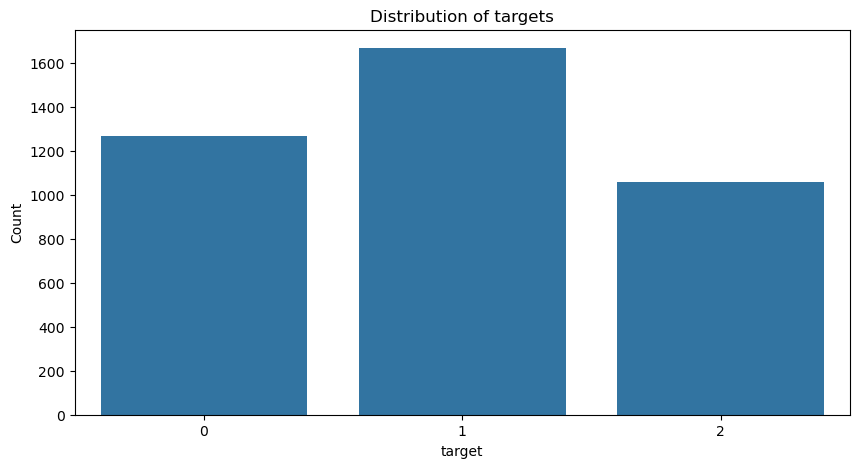

In [43]:
plt.figure(figsize = (10,5))
ax = sns.countplot(x = 'target', data = train_fe)
ax.set(ylabel = 'Count', title = 'Distribution of targets')
plt.show(ax)

